# Automatically generating object masks with SAM

_**Modified from `notebooks/automatic_mask_generator_example.ipynb`**_

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Set-up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import re
import shutil
import sys
import time
import yaml
from collections import defaultdict
from dataclasses import astuple, asdict, dataclass
from datetime import datetime, timedelta
from glob import glob
from operator import itemgetter
from pathlib import Path
from pprint import pprint
from typing import Any, Dict, List, Optional, Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from fastplotlib.widgets import ImageWidget
from numpy.typing import NDArray
from PIL import Image

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

No config found!
EGL says it can present to the window but not natively


Available devices:
✅ (default) | NVIDIA RTX A6000 | DiscreteGPU | Vulkan | 550.107.02
❗ | NVIDIA RTX A6000/PCIe/SSE2 | Unknown | OpenGL | 


In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [4]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from data_utils import get_rng, read_single_image, SegmentationImageIndexer, SegmentationImageSampler, SegmentationVideoIndexer, SegmentationVideoSampler

In [5]:
config_path = 'train_config.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)

# cfg_str = """
# data_files:
#   sp3_vol_01700:
#     image:
#       path: "../wasp_data/vol_01700/img.h5"
#       dataset: "main"
#     label:
#       path: "../wasp_data/vol_01700/label_v3_filled.h5"
#       dataset: "main"
#   sp3_vol_03700:
#     image:
#       path: "../wasp_data/vol_03700/img.h5"
#       dataset: "main"
#     label:
#       path: "../wasp_data/vol_03700/label_v3_filled.h5"
#       dataset: "main"
#   sp3_vol_03998:
#     image:
#       path: "../wasp_data/vol_03998/img.h5"
#       dataset: "main"
#     label:
#       path: "../wasp_data/vol_03998/label.h5"
#       dataset: "main"
# patch_size: [200, 200]
# axis: None
# """
# config = yaml.safe_load(cfg_str)

config

{'train_data_config': {'data_files': {'sp3_vol_01700': {'image': {'path': '../wasp_data/vol_01700/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_01700/label_v3_filled.h5',
     'dataset': 'main'}},
   'sp3_vol_03700': {'image': {'path': '../wasp_data/vol_03700/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_03700/label_v3_filled.h5',
     'dataset': 'main'}}},
  'patch_size': [200, 200],
  'axis': None,
  'rng': 'she sells sea shells'},
 'test_data_config': {'data_files': {'sp3_vol_03998': {'image': {'path': '../wasp_data/vol_03998/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_03998/label.h5', 'dataset': 'main'}}},
  'patch_size': [200, 200],
  'axis': None,
  'rng': 'by the sea shore'},
 'sam2_model_size': 'large',
 'model_checkpoint': 'sam2_hiera_large.pt',
 'model_cfg': 'sam2_hiera_l.yaml',
 'batch_size': 4,
 'num_batches': 5000,
 'learning_rate': 1e-05,
 'weight_decay': 4e-05,
 'checkpoint_interval': 1

In [6]:
train_image_sampler = SegmentationImageSampler.from_config(config['train_data_config'])
test_image_sampler = SegmentationImageSampler.from_config(config['test_data_config'])
train_image_sampler, test_image_sampler

(SegmentationImageSampler(2 volumes, axis=None, patch_size=[200, 200], rng=Generator(PCG64)),
 SegmentationImageSampler(1 volumes, axis=None, patch_size=[200, 200], rng=Generator(PCG64)))

In [7]:
ex_data_index = next(test_image_sampler)
ex_data_index

SegmentationDataIndex(image=HDF5DataIndex(path='../wasp_data/vol_03998/img.h5', dataset='main', slice=(slice(16, 216, None), slice(48, 248, None), 31)), label=HDF5DataIndex(path='../wasp_data/vol_03998/label.h5', dataset='main', slice=(slice(16, 216, None), slice(48, 248, None), 31)))

In [8]:
ex_image = ex_data_index.image.load()
ex_annotation = ex_data_index.label.load()

In [9]:
def get_masks_from_labels(labels, background_label=0) -> List[dict]:
    label_id_counts = dict(list(zip(*np.unique(labels, return_counts=True))))
    if background_label is not None:
        label_id_counts.pop(background_label, None)
    masks = []
    for label_id, count in label_id_counts.items():
        mask = (labels == label_id)
        masks.append({'segmentation': mask, 'area': count})
    return masks


def show_anns(anns, background_label=0, borders=True, rng=42):
    color_rng = get_rng(rng)
    
    if isinstance(anns, np.ndarray):
        anns = get_masks_from_labels(anns)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([color_rng.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            # cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 
            cv2.drawContours(img, contours, -1, color_mask, thickness=1) 

    ax.imshow(img)

## Example image

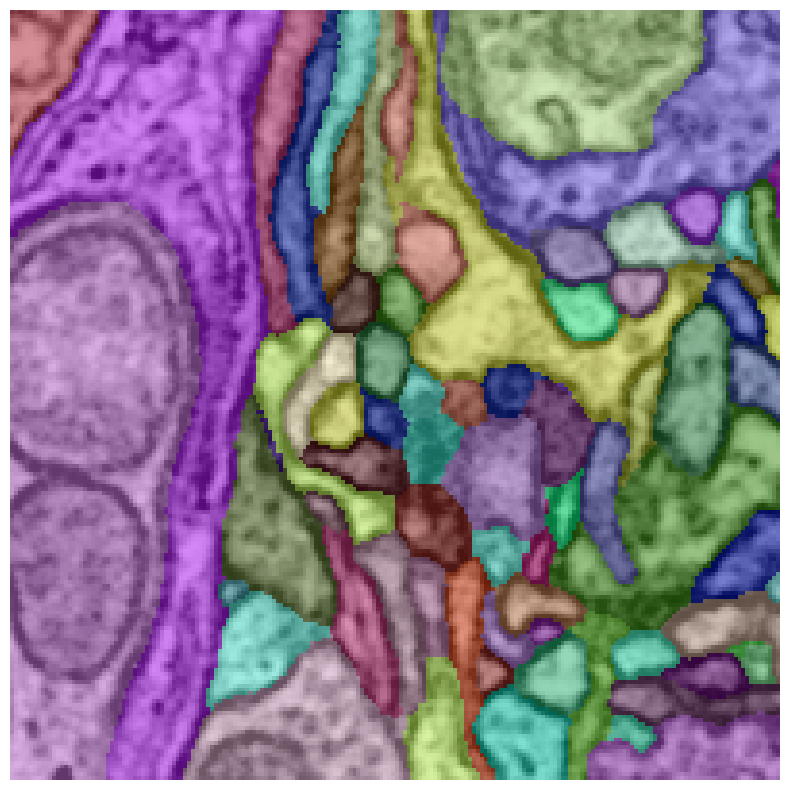

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(ex_image, cmap='grey')
show_anns(ex_annotation, borders=False)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [56]:
image = ex_image[:, :, np.newaxis]
image = np.concatenate([image, image, image], axis=2)

In [57]:
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2, pred_iou_thresh=0.3)

To generate masks, just run `generate` on an image.

In [58]:
masks = mask_generator.generate(image)
print(len(masks_ft2), "segments")

19


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

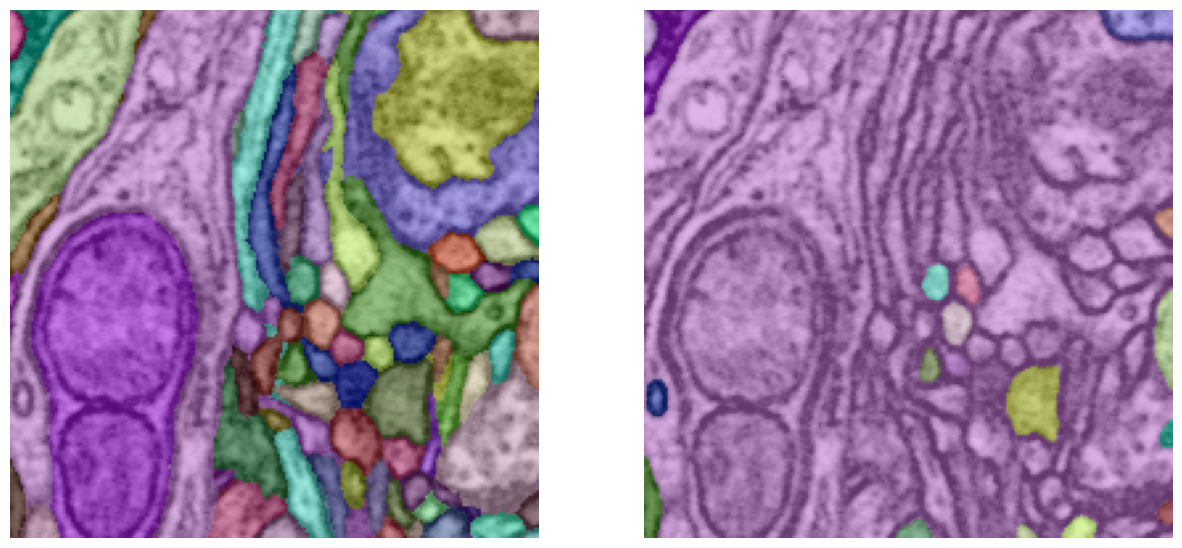

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

plt.sca(axs[0])
plt.imshow(image)
show_anns(ex_annotation, borders=False)
plt.axis('off')

plt.sca(axs[1])
plt.imshow(image)
show_anns(masks)
plt.axis('off')

plt.show()

74 segments


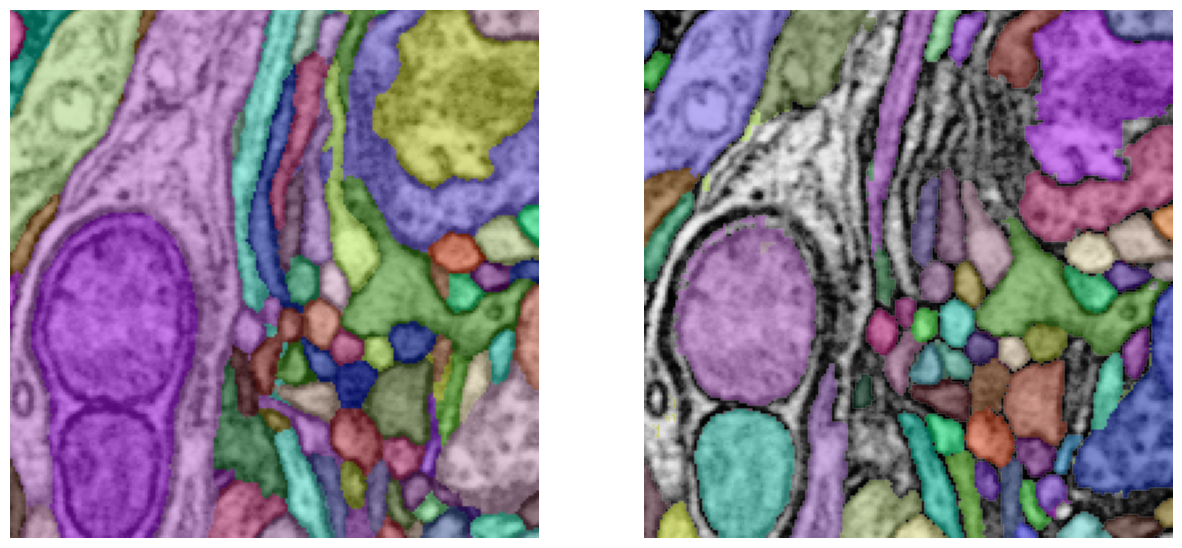

In [69]:
sam2_ft_checkpoint = "tuned_sam_model_20240930T224511.pt"
model_cfg_ft = "sam2_hiera_s.yaml"

sam2_ft = build_sam2(model_cfg_ft, sam2_ft_checkpoint, device=device, apply_postprocessing=False)

mask_generator_ft = SAM2AutomaticMaskGenerator(
    model=sam2_ft,
    pred_iou_thresh=0.5, 
    stability_score_thresh=0.8,
    stability_score_offset=0.7,
    min_mask_region_area=20.0,
)

masks_ft = mask_generator_ft.generate(image)
print(len(masks_ft), "segments")

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

plt.sca(axs[0])
plt.imshow(image)
show_anns(ex_annotation, borders=False)
plt.axis('off')

plt.sca(axs[1])
plt.imshow(image)
show_anns(masks_ft)
plt.axis('off')

plt.show()

74 segments


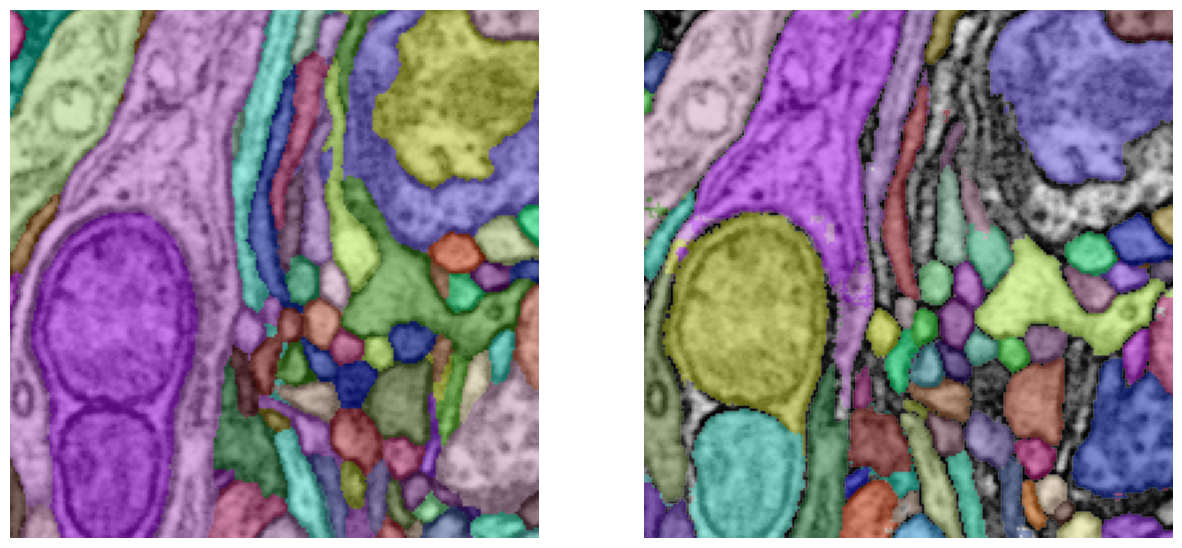

In [70]:
sam2_ft2_checkpoint = "tuned_sam_model_20241001T132911.pt"
model_cfg_ft = "sam2_hiera_s.yaml"

sam2_ft2 = build_sam2(model_cfg_ft, sam2_ft2_checkpoint, device=device, apply_postprocessing=False)

mask_generator_ft2 = SAM2AutomaticMaskGenerator(
    model=sam2_ft2,
    pred_iou_thresh=0.5, 
    stability_score_thresh=0.8,
    stability_score_offset=0.7,
    min_mask_region_area=20.0,
)

masks_ft2 = mask_generator_ft2.generate(image)
print(len(masks_ft2), "segments")

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

plt.sca(axs[0])
plt.imshow(image)
show_anns(ex_annotation, borders=False)
plt.axis('off')

plt.sca(axs[1])
plt.imshow(image)
show_anns(masks_ft2)
plt.axis('off')

plt.show()

75 segments


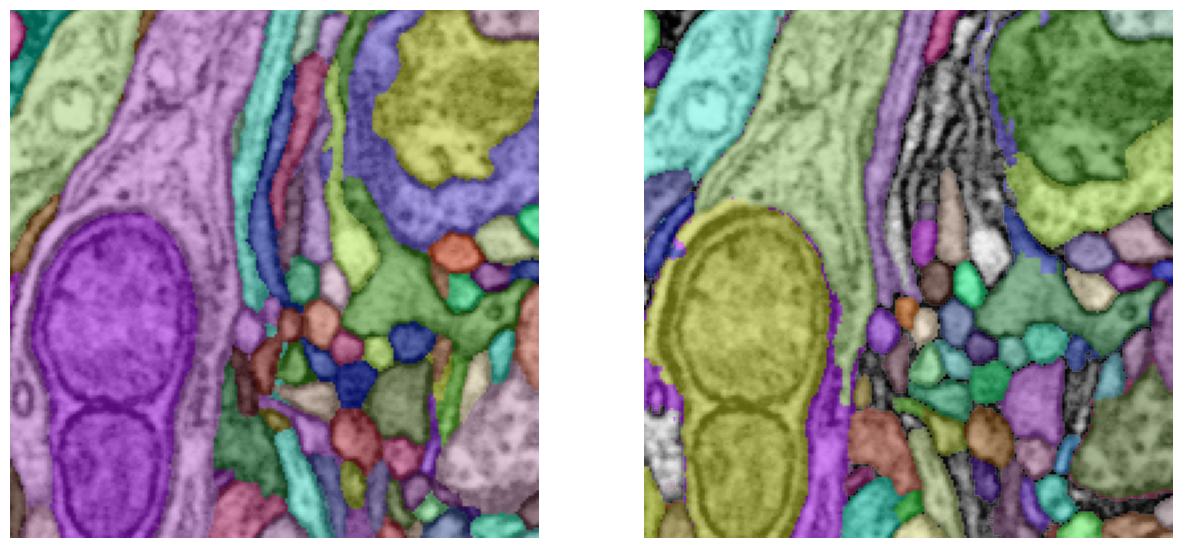

In [72]:
sam2_ft3_checkpoint = "tuned_sam2_large_20241001T143428.5000.pt"
model_cfg_ft3 = "sam2_hiera_l.yaml"

sam2_ft3 = build_sam2(model_cfg_ft3, sam2_ft3_checkpoint, device=device, apply_postprocessing=False)

mask_generator_ft3 = SAM2AutomaticMaskGenerator(
    model=sam2_ft3,
    pred_iou_thresh=0.5, 
    stability_score_thresh=0.8,
    stability_score_offset=0.7,
    min_mask_region_area=20.0,
)

masks_ft3 = mask_generator_ft3.generate(image)
print(len(masks_ft3), "segments")

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

plt.sca(axs[0])
plt.imshow(image)
show_anns(ex_annotation, borders=False)
plt.axis('off')

plt.sca(axs[1])
plt.imshow(image)
show_anns(masks_ft3)
plt.axis('off')

plt.show()

61 segments


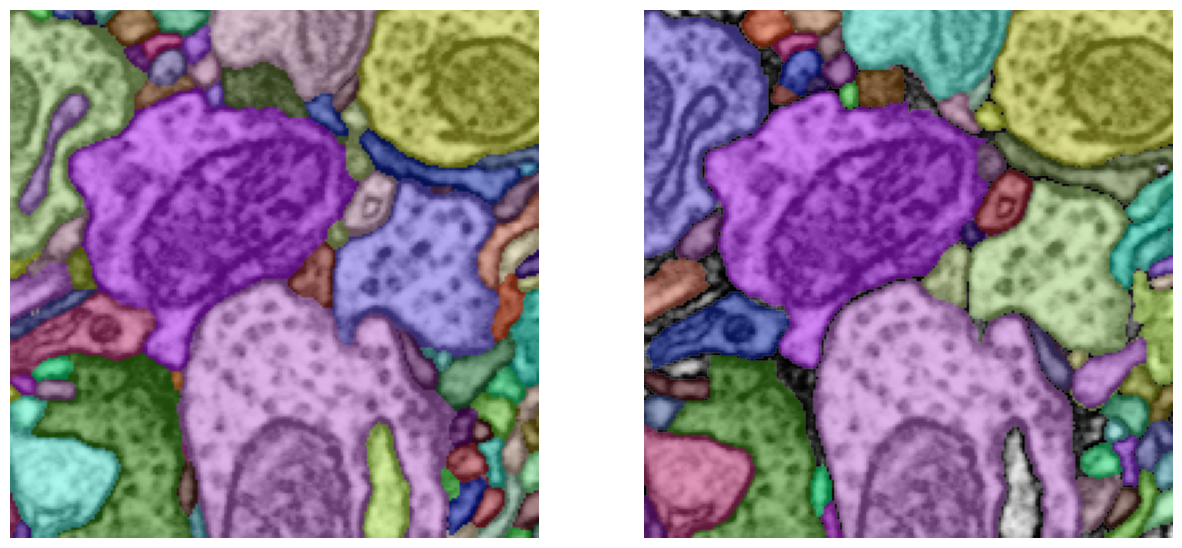

In [14]:
idx2 = train_image_sampler.get_sample(axis=0)
image2 = idx2.image.load()[:, :, np.newaxis]
image2 = np.concatenate([image2, image2, image2], axis=2)
annotation2 = idx2.label.load()

masks2_ft3 = mask_generator_ft3.generate(image2)
print(len(masks2_ft3), "segments")

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

plt.sca(axs[0])
plt.imshow(image2)
show_anns(annotation2, borders=False)
plt.axis('off')

plt.sca(axs[1])
plt.imshow(image2)
show_anns(masks2_ft3)
plt.axis('off')

plt.show()

## Video sampling

In [10]:
train_video_sampler = SegmentationVideoIndexer.from_config(config['train_data_config'], axis=0)
train_video_sampler

SegmentationVideoIndexer(2 volumes, axis=0)

In [11]:
train_video_sampler.list_volumes()

['sp3_vol_01700', 'sp3_vol_03700']

In [12]:
ex_video_idx_1 = train_video_sampler.get_index('sp3_vol_01700', 0, 10, [20, 20], [220, 220])
ex_video_idx_1

SegmentationDataIndex(image=HDF5DataIndex(path='../wasp_data/vol_01700/img.h5', dataset='main', slice=(slice(0, 10, None), slice(20, 220, None), slice(20, 220, None))), label=HDF5DataIndex(path='../wasp_data/vol_01700/label_v3_filled.h5', dataset='main', slice=(slice(0, 10, None), slice(20, 220, None), slice(20, 220, None))))

In [13]:
ex_video_1 = ex_video_idx_1.image.load()
ex_video_1.shape

(10, 200, 200)

In [15]:
iw_movie = ImageWidget(
    data=ex_video_1, 
    cmap="gray",
)
iw_movie.show()

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…